In [27]:
from dotenv import load_dotenv

load_dotenv(verbose=True)

True

In [43]:
### Build Index
from IPython.display import Image, display
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Set embeddings
embd = OpenAIEmbeddings()

# Docs to index
urls = [
    "https://sakana.ai/ai-scientist-jp/",
    "https://sakana.ai/evovlm-jp/",
    "https://sakana.ai/evo-ukiyoe/",
    "https://sakana.ai/evosdxl-jp/",
    "https://sakana.ai/evolutionary-model-merge-jp/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [44]:
doc_splits

[Document(metadata={'source': 'https://sakana.ai/ai-scientist-jp/', 'title': '「AIサイエンティスト」： AIが自ら研究する時代へ', 'language': 'en'}, page_content='「AIサイエンティスト」： AIが自ら研究する時代へ\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n「AIサイエンティスト」： AIが自ら研究する時代へAugust 13, 2024\n\n\n\n\n\n\nSakana\u2005AIは、自然から着想を得たアプローチで最先端の基盤モデルを進化させるという分野を切り開いてきました。今年の3月には、大規模言語モデル（LLM)を含む複数の基盤モデルの統合を自動化する方法を開発し、さらに6月には、LLMを使って、LLMをより効率的にトレーニングする方法を発見しました。\nAIサイエンティスト\nそして今回我々は、「LLMを使って、研究開発プロセスそのものの自動化する」という革新的な技術を開発しました。我々は、これを「AIサイエンティスト」(The AI Scientist)と命名し、オックスフォード大学とブリティッシュ・コロンビア大学との共同研究により、「The AI Scientist: Towards Fully Automated Open-Ended Scientific Discovery」という論文にまとめて公開しました。ソースコードもオープンソース化しています。\nAIサイエンティストは、アイデア創出、実験の実行と結果の要約、論文の執筆及びピアレビューといった科学研究のサイクルを自動的に遂行する新たなAIシステムです。\n最初の実証実験として、AIサイエンティストは、LLM（大規模言語モデル）を活用して機械学習の研究に取り組みました。下記画像は実際に「AIサイエンティスト」が生成した機械学習研究論文の例です。\n\n\nAIサイエンティストが実際に作成した論文の例（「Adaptive Dual-Scale Denoising」）はこちらで見ることができます。\n\n\n特筆すべき点は、最初の準備以外、一切人間の介入なしで、このシステムが機械学習研

In [45]:
# Add to vectorstore
vectorstore = FAISS.from_documents(
    documents=doc_splits,
    embedding=embd,
)
retriever = vectorstore.as_retriever()


In [46]:
### Router

from typing import Literal

from langchain_community.chat_models import ChatPerplexity
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# NOTE: you must use langchain-core >= 0.3 with Pydantic v2
from pydantic import BaseModel, Field


# Data model
class RouteQuery(BaseModel):
    """ユーザークエリを最も関連性の高いデータソースにルーティングする。"""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="ユーザーの質問に対して、ウェブ検索かベクターストアのどちらかを選択する。",
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
# llm = ChatPerplexity(temperature=0.7, model="llama-3.1-sonar-small-128k-chat")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """あなたはユーザーの質問をウェブ検索やベクターストアにルーティングするエキスパートです。
ベクターストアにはSakana AI社に関するブログ情報（進化的モデルマージ、AIサイエンティスト）が含まれています。
これらのトピックに関する質問にはベクターストアを使用してください。それ以外はウェブ検索を使用してください。"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
# print(
#     question_router.invoke(
#         {"question": "Who will the Bears draft first in the NFL draft?"}
#     )
# )
# print(question_router.invoke({"question": "What are the types of agent memory?"}))


In [47]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """検索された文書の関連性チェックのためのバイナリスコア。"""

    binary_score: str = Field(
        description="文書が質問に関連しているか、「はい」か「いいえ」か"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """あなたは、検索された文書とユーザーの質問との関連性を評価する採点者です。\n 
    文書がユーザの質問に関連するキーワードまたは意味的な意味を含んでいる場合、関連性があると評定します。\n
    厳密なテストである必要はありません。目的は誤った検索を除外することです。\n
    文書が質問に関連しているかどうかを示すために、「はい」または「いいえ」のバイナリスコアを与えます。"""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "取得したドキュメント: \n\n {document} \n\n ユーザーの質問: {question}",
        ),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
# question = "agent memory"
# docs = retriever.invoke(question)
# doc_txt = docs[1].page_content
# print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


In [48]:
### Generate

from langchain_core.output_parsers import StrOutputParser

from langchain import hub

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# # Run
# generation = rag_chain.invoke({"context": docs, "question": question})
# print(generation)


In [49]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """生成結果にハルシネーションが含まれるかチェックのためのバイナリスコア。"""

    binary_score: str = Field(
        description="答えは事実に基づいているか、「はい」か「いいえ」か"
    )


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """あなたは、LLMの生成結果が事実に基づいたものか/裏付けがあるかどうかを評価する採点者です。「はい」か「いいえ」で採点してください。「はい」は、答えが事実に基づいている／事実によって裏付けられていることを意味します。"""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "事実: \n\n {documents} \n\n LLMの生成結果: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
# hallucination_grader.invoke({"documents": docs, "generation": generation})


In [50]:
### Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """質問に対する回答を評価するためのバイナリスコア。"""

    binary_score: str = Field(description="質問に「はい」か「いいえ」で答える")


# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """あなたは採点者であり、回答が質問を解決しているかどうかを評価します。「はい」か「いいえ」で採点してください。「はい」は答えが質問を解決していることを意味します。"""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "ユーザーの質問: \n\n {question} \n\n LLMの生成結果: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
# answer_grader.invoke({"question": question, "generation": generation})


In [51]:
### Question Re-writer

# LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """あなたは入力された質問をベクトルストア検索に最適化された質問に書き換える人です。最初の質問に対して、根底にある意味的な意図/意味を推論し、より良い質問に書き換えてください。"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "これが最初の質問です。: \n\n {question} \n より良い質問に書き換えてください。",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
# question_rewriter.invoke({"question": question})


In [52]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)


In [53]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]


In [54]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "はい":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "はい":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "はい":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"


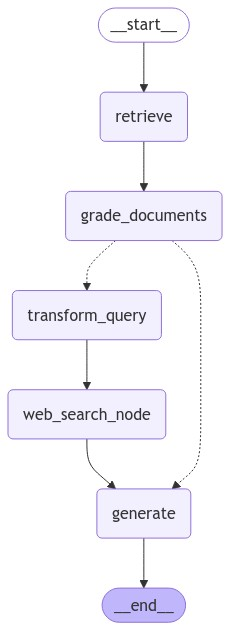

In [55]:
from langgraph.graph import END, START, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


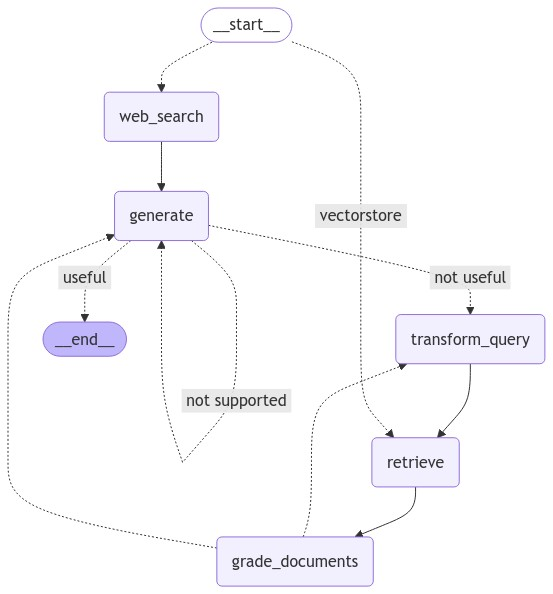

In [23]:
from langgraph.graph import END, START, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)
# Compile
app = workflow.compile()


try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [56]:
from pprint import pprint

# Run
inputs = {
    "question": "SAKANA AI社の進化的モデルマージについてわかりやすく説明してください。また当該技術を金融機関（銀行・証券・信託）で使うとしたら、どのようなユースケースが考えられるか、考えてください。"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])


---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---


ValidationError: 1 validation error for GradeDocuments
binary_score
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing